In [1]:
from pip._internal import main as pip

try:
    import pprint
except ImportError:
    pip(['install', 'pprint'])
    import pprint

try:
    import requests
except ImportError:
    pip(['install', 'requests'])
    import requests

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd

try:
    import simplejson as json
except ImportError:
    pip(['install', 'simplejson'])
    import simplejson as json

import re
    
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_columns', 99999)

## Select EdelweissData server and authenticate

In [2]:
try:
    from edelweiss_data import API, QueryExpression as Q
except ImportError:
    pip(['install', 'edelweiss_data'])
    from edelweiss_data import API, QueryExpression as Q

edelweiss_api_url = 'https://api.staging.kit.cloud.douglasconnect.com'
api = API(edelweiss_api_url)
api.authenticate()

## Select compound and gene of interest
The selections are based on the work performed in the OpenRiskNet AOPlink case study, where specific stressors and genes associated with key events of a specific AOP are extracted from AOPWiki and AOP-DB

In [3]:
geneSymbol = 'PPARA'
compounds = ['117-81-7', '25812-30-0', '3771-19-5', '41859-67-0', '49562-28-9', '50892-23-4', '52214-84-3', '637-07-0']

InChIKeys = []
for compound in compounds:
    request = requests.get('https://chemidconvert.prod.openrisknet.org/v1/cas/to/inchikey', params={'cas': compound})
    InChIKeys.append(request.json()['inchikey'])
InChIKeys

['BJQHLKABXJIVAM-UHFFFAOYSA-N',
 'HEMJJKBWTPKOJG-UHFFFAOYSA-N',
 'XJGBDJOMWKAZJS-UHFFFAOYSA-N',
 'IIBYAHWJQTYFKB-UHFFFAOYSA-N',
 'YMTINGFKWWXKFG-UHFFFAOYSA-N',
 'SZRPDCCEHVWOJX-UHFFFAOYSA-N',
 'KPSRODZRAIWAKH-UHFFFAOYSA-N',
 'KNHUKKLJHYUCFP-UHFFFAOYSA-N']

## Collect metadata of all ToxCast and TG-GATEs sets on the server and select sets with biological target gene of interest

In [4]:
columns = [
#    ("Endpoint", "$.assay.component.endpoint"),
    ("Endpoint name", "$.assay.component.endpoint.assay_component_endpoint_name.value"),
    ("Biological target", "$.assay.component.endpoint.target.biological_process_target.value"),
    ("Entrez gene ID for the molecular target", "$.assay.component.endpoint.target.intended.intended_target_gene.intended_target_entrez_gene_id.value"),
    ("Symbol", "$.assay.component.endpoint.target.intended.intended_target_gene.intended_target_official_symbol.value"),
    ("Gene name", "$.assay.component.endpoint.target.intended.intended_target_gene.intended_target_gene_name.value"),
    ("Compounds", "$.compound"),
]

condition = Q.search_anywhere("EPA-ToxCast") & Q.search_anywhere("summary") 
condition = condition & Q.fuzzy_search(Q.column('Symbol'), geneSymbol)

cquery = None
for compound in InChIKeys:
    if cquery is None:
        cquery = Q.fuzzy_search(Q.column('Compounds'), compound)
    else:
        cquery = cquery | Q.fuzzy_search(Q.column('Compounds'), compound)
condition =  condition & cquery

ToxCast = api.get_published_datasets(limit=20, columns=columns, condition=condition)

ToxCast.drop(['Compounds'], axis=1, inplace=True)
#ToxCast

In [5]:
columns = [
#    ("Metadata", "$"),
    ("Compound", "$.Compound.Name"),
    ("InChI key", "$.Compound.\"InChI Key\""),
    ("Organism", "$.Assay.Organism"),
    ("Study type", "$.Assay.\"Study type\""),
    ("Organ", "$.Assay.Organ"),
    ("Dose", "$.Assay.Exposure.Dose"),
    ("Duration", "$.Assay.Exposure.Duration")
]
condition = Q.search_anywhere("TG-GATES") & Q.search_anywhere("FOLD_CHANGES")
condition = condition & Q.fuzzy_search(Q.column('Organism'), 'Human')
condition = condition & Q.fuzzy_search(Q.column('Organ'), 'Liver')
condition = condition & Q.fuzzy_search(Q.column('Study type'), 'in_vitro')
condition = condition & Q.fuzzy_search(Q.column('Dose'), 'high')

cquery = False

TGGATEs = pd.DataFrame()
for compound in InChIKeys:
    cquery = condition & Q.fuzzy_search(Q.column('InChI key'), compound)
    TGGATEs = pd.concat([TGGATEs, api.get_published_datasets(limit=200, columns=columns, condition=cquery)])
#TGGATEs

## Extract data for compound from selected datasets

In [6]:
ToxCastData = pd.DataFrame()
for index, row in ToxCast.iterrows():
    cquery = None
    for compound in InChIKeys:
        if cquery is None:
            cquery = Q.fuzzy_search(Q.column('InChI key'), compound)
        else:
            cquery = cquery | Q.fuzzy_search(Q.column('InChI key'), compound)

    tmpdata = row['dataset'].get_data(condition = cquery)

    tmpdata = tmpdata[tmpdata['InChI key'].isin(InChIKeys)]
    tmpdata['Assay']=row['Endpoint name']
    tmpdata = tmpdata[['Assay', 'DTXSID', 'Substance name', 'InChI key', 'CAS', 'IC50']]
    ToxCastData = pd.concat([ToxCastData, tmpdata])
    
ToxCastData.sort_values(by=['InChI key','Assay'])

,Assay,DTXSID,Substance name,InChI key,CAS,IC50
3780,ATG_PPARa_TRANS_dn,DTXSID5020607,Di(2-ethylhexyl) phthalate,BJQHLKABXJIVAM-UHFFFAOYSA-N,117-81-7,NaN
3886,ATG_PPARa_TRANS_up,DTXSID5020607,Di(2-ethylhexyl) phthalate,BJQHLKABXJIVAM-UHFFFAOYSA-N,117-81-7,NaN
3849,ATG_PPRE_CIS_dn,DTXSID5020607,Di(2-ethylhexyl) phthalate,BJQHLKABXJIVAM-UHFFFAOYSA-N,117-81-7,NaN
4018,ATG_PPRE_CIS_up,DTXSID5020607,Di(2-ethylhexyl) phthalate,BJQHLKABXJIVAM-UHFFFAOYSA-N,117-81-7,1.414849
33,NVS_NR_hPPARa,DTXSID5020607,Di(2-ethylhexyl) phthalate,BJQHLKABXJIVAM-UHFFFAOYSA-N,117-81-7,NaN
936,ATG_PPARa_TRANS_dn,DTXSID0020652,Gemfibrozil,HEMJJKBWTPKOJG-UHFFFAOYSA-N,25812-30-0,NaN
964,ATG_PPARa_TRANS_up,DTXSID0020652,Gemfibrozil,HEMJJKBWTPKOJG-UHFFFAOYSA-N,25812-30-0,1.558449
954,ATG_PPRE_CIS_dn,DTXSID0020652,Gemfibrozil,HEMJJKBWTPKOJG-UHFFFAOYSA-N,25812-30-0,NaN
982,ATG_PPRE_CIS_up,DTXSID0020652,Gemfibrozil,HEMJJKBWTPKOJG-UHFFFAOYSA-N,25812-30-0,1.509815
3306,ATG_PPARa_TRANS_dn,DTXSID3029869,Bezafibrate,IIBYAHWJQTYFKB-UHFFFAOYSA-N,41859-67-0,NaN


In [7]:
condition = Q.fuzzy_search(Q.column('SYMBOL'), 'PPARA')

foldChanges = pd.DataFrame()

for index, row in TGGATEs.iterrows():
    tmpdata = row['dataset'].get_data(condition=condition)
#    tmpdata = row['dataset'].get_data(limit=2)
    tmpdata['dataset'] = row['dataset']
    foldChanges = pd.concat([foldChanges, tmpdata])

TGGATEsData = pd.merge(TGGATEs, foldChanges, on='dataset')    
TGGATEsData.drop(['dataset', 'ENSEMBL', 'ENTREZID'], axis=1, inplace=True)
#TGGATEsData.sort_values(by=['InChI key','Study type', 'Dose', 'Duration'])
TGGATEsData

,Compound,InChI key,Organism,Study type,Organ,Dose,Duration,PROBEID,SYMBOL,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,206870_at,PPARA,0.161344,0.716027,4.055956,4.999891e-05,0.007388,1.711434
1,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,223437_at,PPARA,0.145851,1.193995,3.666473,2.461514e-04,0.022135,0.276228
2,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,1558631_at,PPARA,0.135322,0.698542,3.401782,6.699593e-04,0.041111,-0.616511
3,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,244689_at,PPARA,0.127207,1.008897,3.197788,1.385647e-03,0.066398,-1.258910
4,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,226978_at,PPARA,0.100995,1.293303,2.538869,1.112390e-02,0.211599,-3.062608
5,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,210771_at,PPARA,0.064561,0.332642,1.622977,1.046001e-01,0.568553,-4.881483
6,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,1560981_a_at,PPARA,0.041624,0.506034,1.046356,2.954015e-01,0.783652,-5.615939
7,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,8,223438_s_at,PPARA,0.041606,0.901968,1.045919,2.956030e-01,0.783673,-5.616375
8,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,24,226978_at,PPARA,0.093457,1.309797,2.714771,6.634240e-03,0.199630,-2.620944
9,gemfibrozil,InChIKey=HEMJJKBWTPKOJG-UHFFFAOYSA-N,Human,in_vitro,Liver,high,24,1558631_at,PPARA,0.092454,0.776397,2.685636,7.241373e-03,0.209663,-2.696015


## Visualize values as heatmaps

### ToxCast data 

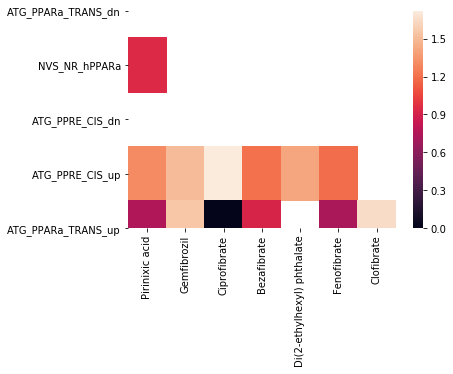

In [8]:
try:
    import seaborn as sns
except ImportError:
    pip(['install', 'seaborn'])
    import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

cnames = ToxCastData['Substance name'].unique().tolist()
indexes = ToxCastData['Assay'].unique().tolist()
ToxCastHeatMap = pd.DataFrame(columns=cnames, index=indexes)
for compound in cnames:    
    tmpdf =  ToxCastData[ToxCastData['Substance name'] == compound][['Assay', 'IC50']]

    indexes = tmpdf.set_index('Assay').index
    ToxCastHeatMap.loc[indexes, compound] = tmpdf['IC50'].tolist()

fig, ax = plt.subplots()
sns.heatmap(ToxCastHeatMap.fillna(0), mask= pd.isna(ToxCastHeatMap), ax=ax)

### TG-GATEs data 

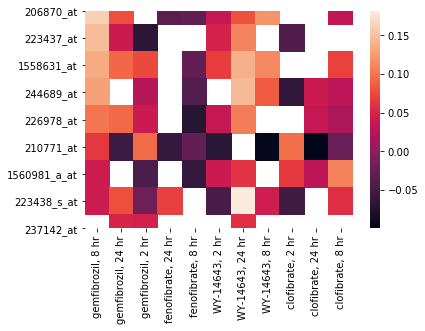

In [9]:
TGGATEsData['newCol'] = TGGATEsData['Compound'] + ', ' + TGGATEsData['Duration'].astype(str) + ' hr'
conditions = TGGATEsData['newCol'].unique().tolist()
indexes = TGGATEsData['PROBEID'].unique().tolist()
TGGATEsHeatMap = pd.DataFrame(columns=conditions, index=indexes)

for condition in conditions:    
    tmpdf =  TGGATEsData[TGGATEsData['newCol'] == condition][['PROBEID', 'logFC']]

    indexes = tmpdf.set_index('PROBEID').index
    TGGATEsHeatMap.loc[indexes, condition] = tmpdf['logFC'].tolist()

TGGATEsData.drop(['newCol'], inplace=True, axis=1)

fig, ax = plt.subplots()
sns.heatmap(TGGATEsHeatMap.fillna(0), mask= pd.isna(TGGATEsHeatMap), ax=ax)
